In [1333]:
import pickle
import copy

import alphashape as ashp
import pandas as pd
import numpy as np
import colorcet as cc
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import block_diag
from filterpy.kalman import KalmanFilter, MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF

from tqdm import tqdm
from matplotlib import colors
from pyproj import Proj

In [1334]:
plt.style.use('dark_background')

In [1335]:
H5_PATH = '/home/yang/output/eswe/imm/'
OUTPUT_PATH = '/home/yang/output/eswe/smooth/'
EVENT = 'jkwh'
MACHINE_ID = '6130'
DATE = '072017'
FIELD_ID = 'f2'
log_name = '-'.join([EVENT, MACHINE_ID, DATE, FIELD_ID, 'gps-imm.h5'])

In [1336]:
# Load in data
gps = pd.read_hdf(H5_PATH + log_name)

In [1337]:
gps.head()

,machine_id,ts,lat,lon,alt,speed,track,accuracies,x,y,ts_local,cv_prob,nct_prob
0,p and e 6130,1499551475,40.677378,-102.144476,1095.300049,0.5,49.5,4,741336.285255,4.506866e+06,2017-07-08 16:04:35,0.499834,0.500166
1,p and e 6130,1499551476,40.677383,-102.144474,1095.300049,0.5,49.5,3,741336.459602,4.506866e+06,2017-07-08 16:04:36,0.499072,0.500928
2,p and e 6130,1499551477,40.677389,-102.144472,1095.400024,0.5,49.5,3,741336.646911,4.506867e+06,2017-07-08 16:04:37,0.503574,0.496426
3,p and e 6130,1499551478,40.677395,-102.144470,1095.400024,0.5,49.5,3,741336.785910,4.506867e+06,2017-07-08 16:04:38,0.545249,0.454751
4,p and e 6130,1499551479,40.677401,-102.144468,1095.699951,0.5,49.5,3,741336.935603,4.506868e+06,2017-07-08 16:04:39,0.693842,0.306158


<IPython.core.display.Javascript object>


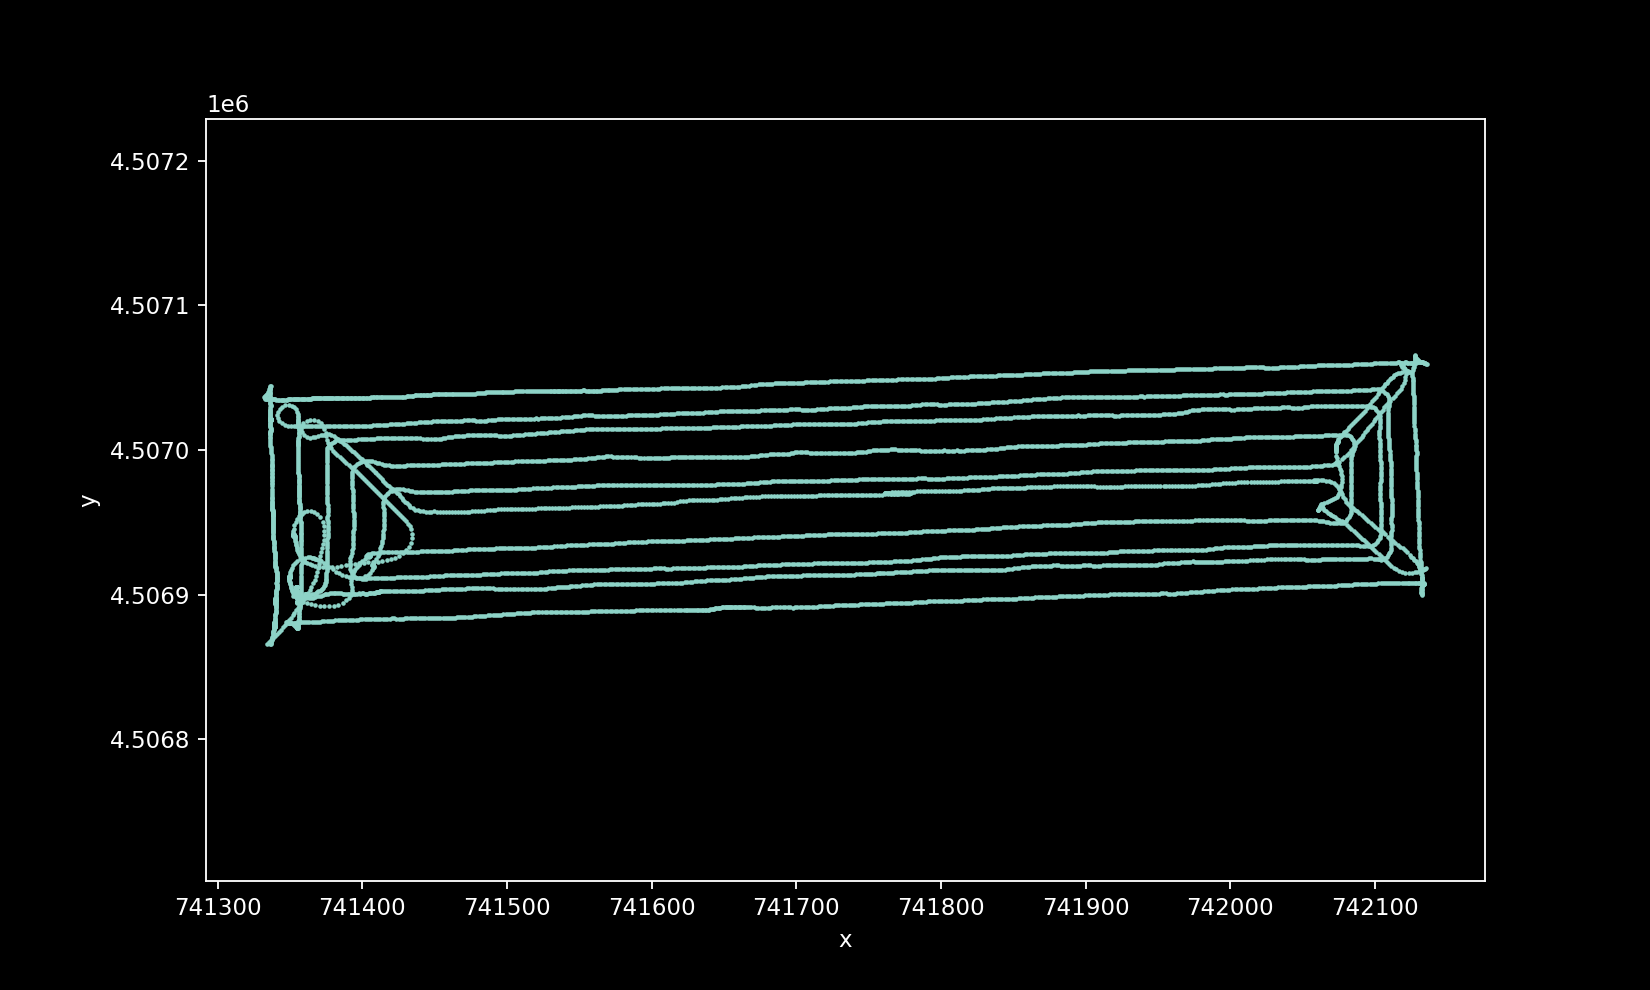

(741291.9831322336, 742176.1652641689, 4506855.602137058, 4507075.415740121)

In [1338]:
fig, ax = plt.subplots(figsize=(10,6))
gps.plot.scatter(x='x', y='y', s=1, ax=ax)
ax.axis('equal')

In [1339]:
# Before smoothing, let's see if there is any gap in data points
# We need to break these different segments into groups and then smooth each group

# Compute time difference
gps_seg = gps.copy()
gps_seg['ts_diff'] = gps_seg['ts'].diff()
gps_seg.loc[0, 'ts_diff'] = 0

# A trick vector that could be used for grouping
gps_seg['ts_diff_binary'] = gps_seg['ts_diff'] > 1
gps_seg['ts_diff_binary_cumsum'] = gps_seg['ts_diff_binary'].apply(lambda x: 1 if x else 0).cumsum()

# Points groups
grp = gps_seg.groupby('ts_diff_binary_cumsum')

# Make indices right
gps_seg['seg_num'] = grp.ngroup()
gps_seg.loc[0, 'seg_num'] = 0

In [1340]:
print(gps_seg['seg_num'].unique())

[0]


In [1341]:
# Allocate space for smoothed x, y
gps_s = gps.copy()
gps_s['xs'] = np.nan
gps_s['ys'] = np.nan

In [1342]:
# Define CA Kalman filter
dt = 1
r = 9 # 9 seems to be the magic value
ca = KalmanFilter(6, 2)
dt2 = (dt**2)/2
F = np.array([[1, dt, dt2],
              [0,  1,  dt],
              [0,  0,   1]])
            
ca.F = block_diag(F, F)
ca.P *= 1e-6
ca.R *= r**2
q = np.array([[.05, .125, 1/6],
              [.125, 1/3, .5],
              [1/6, .5, 1]])*1.e-2
ca.Q = block_diag(q, q)
ca.H = np.array([[1, 0, 0, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0]])

In [1343]:
for n in tqdm(gps_seg['seg_num'].unique()):
    # Get the track segment
    seg = gps_seg.loc[gps_seg['seg_num'] == n, ['x', 'y']]
    z = np.vstack([seg['x'].values, seg['y'].values]).T
    # Filter data with CA Kalman filter, than run smoother on it
    ca.x = np.array([z[0,0], 0, 0, z[0,1], 0, 0])
    mu, cov, _, _ = ca.batch_filter(z)
    xs, Ps, C, _ = ca.rts_smoother(mu, cov)
    # Assign the smoothed estimates to the original df
    gps_s.loc[gps_seg['seg_num'] == n, 'xs'] = xs[:,0]
    gps_s.loc[gps_seg['seg_num'] == n, 'ys'] = xs[:,3]

100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


<IPython.core.display.Javascript object>


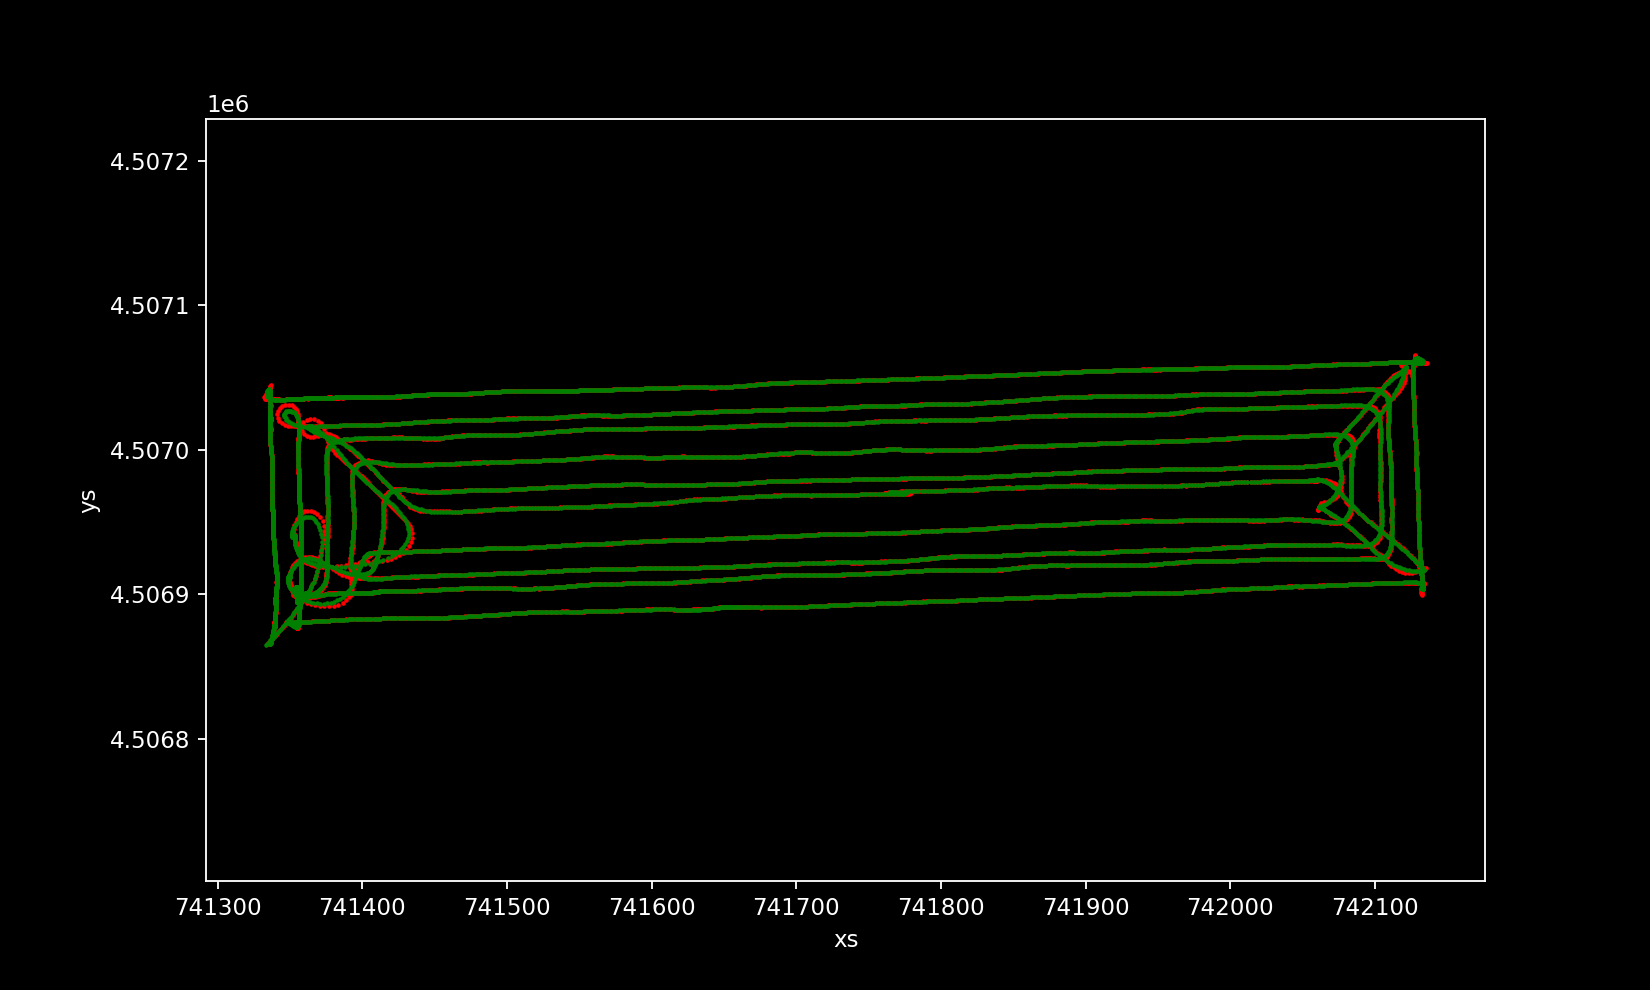

(741291.9831322336, 742176.1652641689, 4506855.149446989, 4507075.437296791)

In [1344]:
# %matplotlib notebook
fig, ax = plt.subplots(figsize=(10,6))
gps.plot.scatter(x='x', y='y', c='r', s=1, ax=ax)
gps_s.plot.scatter(x='xs', y='ys', c='g', s=1, ax=ax)
ax.axis('equal')

In [1345]:
gps_s.to_hdf(OUTPUT_PATH + '-'.join([EVENT, MACHINE_ID, DATE, FIELD_ID, 'gps-sm-t.h5']), \
             data_columns=['ts', 'xs', 'ys'], \
             key='df', mode='w')

In [1346]:
# # Now we want to identify whether or not the machine was turning
# # Obtain a copy of original df and assign `turn` to nan
# gps_c = gps.copy()
# gps_c['turning'] = np.nan

In [1347]:
# # Get the turning suspect points from any point that has NCT prob > 0.5
# turn_susp = gps_c[gps_c['nct_prob'] > 0.5]

In [1348]:
# fig, ax = plt.subplots(figsize=(10,6))
# turn_susp.plot.scatter(x='x', y='y', s=1, c='r', ax=ax)
# ax.axis('equal')

In [1349]:
# # Now let's group them using ST-DBSCAN
# # Compute time distance
# t_dist = squareform(pdist(turn_susp['ts'].values.reshape(len(turn_susp),1), metric='euclidean'))
# # Compute coordinate distance
# pt_dist = squareform(pdist(np.vstack([turn_susp['x'].values, turn_susp['y'].values]).T, metric='euclidean'))
# # Make coordinate distance bigger when time are far apart
# pt_dist_st = np.where(t_dist <= 10, pt_dist, 10*pt_dist)

In [1350]:
# # Now perform DBSCAN
# c_stdbscan = DBSCAN(eps=5, min_samples=2, metric='precomputed').fit(pt_dist_st)

In [1351]:
# print(set(c_stdbscan.labels_))

In [1352]:
# # Assign the cluster label onto the df
# turn_susp_c = turn_susp.copy()
# turn_susp_c['stdbscan_label'] = c_stdbscan.labels_

In [1353]:
# fig, ax = plt.subplots(figsize=(10,6))
# turn_susp_c.plot.scatter(x='x', y='y', s=1, c='stdbscan_label', cmap=cc.cm.glasbey_dark, colorbar=False, ax=ax)
# ax.axis('equal')

In [1354]:
# # For noise labels, let's assume that they are valid straight pts,
# # so we will reassign these as straight
# turn_susp_c.loc[turn_susp_c['stdbscan_label'] == -1, 'turning'] = 0

In [1355]:
# # Let's look at the rest
# stdbscan_labels = turn_susp_c['stdbscan_label'].unique().tolist()
# stdbscan_labels.remove(-1)
# # Use a number to keep track of actual non working points
# turn_num = 0
# for l in stdbscan_labels:
#     tmp = turn_susp_c.loc[turn_susp_c['stdbscan_label'] == l, :]
# #     print('Segment length: {} | Average speed: {:.2f} | Max track chg: {:.2f}'.format(\
# #         len(tmp), tmp['speed'].mean(), \
# #         np.nanmax(pdist(tmp['track'].values.reshape(len(tmp['track']),1), lambda u, v: (360-abs(u-v)) if (abs(u-v)) > 180 else abs(u-v)))))
#     # Only label a series of points as turning if the segment 
#     if np.nanmax(pdist(tmp['track'].values.reshape(len(tmp['track']),1), lambda u, v: (360-abs(u-v)) if (abs(u-v)) > 180 else abs(u-v))) > 90:
#         turn_susp_c.loc[turn_susp_c['stdbscan_label'] == l, 'turning'] = 1
#         turn_num += 1
#     else:
#         turn_susp_c.loc[turn_susp_c['stdbscan_label'] == l, 'turning'] = 0

In [1356]:
# print(turn_num, len(stdbscan_labels))

In [1357]:
# # Some segments are relabled as straight (red)
# fig, ax = plt.subplots(figsize=(10,6))
# turn_susp_c[turn_susp_c['turning'] == 1].plot.scatter(x='x', y='y', s=1, c='g', ax=ax)
# turn_susp_c[turn_susp_c['turning'] == 0].plot.scatter(x='x', y='y', s=1, c='r', ax=ax)
# ax.axis('equal')

In [1358]:
# gps_c['turning'] = 0
# gps_c.loc[turn_susp_c[turn_susp_c['turning'] == 1].index, 'turning'] = 1

In [1359]:
# fig, ax = plt.subplots(figsize=(10,6))
# gps_c.plot.scatter(x='x', y='y', c='turning', s=1, cmap=cc.cm.glasbey_dark, colorbar=False, ax=ax)
# ax.axis('equal')

In [1360]:
# # Now we want to break our track into segments and filter them using different models
# cv_grp = gps_c[gps_c['turning'] == 0].copy()
# nct_grp = gps_c[gps_c['turning'] == 1].copy()

In [1361]:
# # Let's do the cv group first
# # TODO: Wow why is it a string, need to fix!!!!!!
# cv_grp['ts'] = cv_grp['ts'].astype('int')

In [1362]:
# cv_grp['ts_diff'] = cv_grp['ts'].diff()

In [1363]:
# cv_grp.loc[0, 'ts_diff'] = 0

In [1364]:
# cv_grp['ts_diff_binary'] = cv_grp['ts_diff'] > 1
# cv_grp['ts_diff_binary_cumsum'] = cv_grp['ts_diff_binary'].apply(lambda x: 1 if x else 0).cumsum()

In [1365]:
# # Points groups
# cv_grps = cv_grp.groupby('ts_diff_binary_cumsum')

In [1366]:
# # Make indices right
# cv_grp['grp_num'] = cv_grps.ngroup()
# cv_grp.loc[0, 'grp_num'] = 0

In [1367]:
# fig, ax = plt.subplots(figsize=(10,6))
# cv_grp.plot.scatter(x='x', y='y', c='grp_num', s=1, cmap=cc.cm.glasbey_dark, colorbar=False, ax=ax)
# ax.axis('equal')

In [1368]:
# Now let's filter each segments using a CA model
# Set the model up first
# dt = 1
# cv = KalmanFilter(4, 2)
# cv.F = np.array([[1, dt, 0, 0], \
#                  [0, 1, 0, 0], \
#                  [0, 0, 1, dt], \
#                  [0, 0, 0, 1]])
# cv.P *= 1e-2
# cv.R = np.diag([0.05, 0.05])
# q_cv = 1e-3
# cv.Q = np.array([[1/3*(dt**3), 1/2*(dt**2), 0, 0], \
#                  [1/2*(dt**2), dt, 0, 0], \
#                  [0, 0, 1/3*(dt**3), 1/2*(dt**2)], \
#                  [0, 0, 1/2*(dt**2), dt]])*q_cv
# cv.H = np.array([[1, 0, 0, 0],
#                  [0, 0, 1, 0]])
# dt = 1
# r = 5
# ca = KalmanFilter(6, 2)
# dt2 = (dt**2)/2
# F = np.array([[1, dt, dt2],
#               [0,  1,  dt],
#               [0,  0,   1]])
            
# ca.F = block_diag(F, F)
# ca.P *= 1e-6
# ca.R *= r**2
# q = np.array([[.05, .125, 1/6],
#               [.125, 1/3, .5],
#               [1/6, .5, 1]])*1.e-2
# ca.Q = block_diag(q, q)
# ca.H = np.array([[1, 0, 0, 0, 0, 0],
#                  [0, 0, 0, 1, 0, 0]])

In [1369]:
# # Allocate space for smoothed x, y
# cv_grp_s = cv_grp.copy()
# cv_grp_s['xs'] = np.nan
# cv_grp_s['ys'] = np.nan

In [1370]:
# for n in tqdm(cv_grp_s['grp_num'].unique()):
#     # Get the track segment
#     seg = cv_grp_s.loc[cv_grp_s['grp_num'] == n, ['x', 'y']]
#     z = np.vstack([seg['x'].values, seg['y'].values]).T
#     # Filter data with cv Kalman filter, than run smoother on it
#     ca.x = np.array([z[0,0], 0, 0, z[0,1], 0, 0])
#     mu, cov, _, _ = ca.batch_filter(z)
#     xs, Ps, C, _ = ca.rts_smoother(mu, cov)
#     # Assign the smoothed estimates to the original df
#     cv_grp_s.loc[cv_grp_s['grp_num'] == n, 'xs'] = xs[:,0]
#     cv_grp_s.loc[cv_grp_s['grp_num'] == n, 'ys'] = xs[:,3]

In [1371]:
# # %matplotlib notebook
# fig, ax = plt.subplots(figsize=(10,6))
# cv_grp_s.plot.scatter(x='xs', y='ys', c='g', s=5, ax=ax)
# cv_grp_s.plot.scatter(x='x', y='y', c='r', s=1, ax=ax)
# ax.axis('equal')

In [1372]:
# # Now let's do the same thing for the turning segments
# # TODO: Wow why is it a string, need to fix!!!!!!
# nct_grp['ts'] = nct_grp['ts'].astype('int')

In [1373]:
# nct_grp['ts_diff'] = nct_grp['ts'].diff()
# nct_grp.loc[0, 'ts_diff'] = 0
# nct_grp['ts_diff_binary'] = nct_grp['ts_diff'] > 1
# nct_grp['ts_diff_binary_cumsum'] = nct_grp['ts_diff_binary'].apply(lambda x: 1 if x else 0).cumsum()

In [1374]:
# # Points groups
# nct_grps = nct_grp.groupby('ts_diff_binary_cumsum')

In [1375]:
# # Make indices right
# nct_grp['grp_num'] = nct_grps.ngroup()
# nct_grp.loc[0, 'grp_num'] = 0

In [1376]:
# fig, ax = plt.subplots(figsize=(10,6))
# nct_grp.plot.scatter(x='x', y='y', c='grp_num', s=1, cmap=cc.cm.glasbey_dark, colorbar=False, ax=ax)
# ax.axis('equal')

In [1377]:
# # UKF f, h definitions
# def f_nct(x, dt):
#     F = np.array([[1, np.sin(x[4]*dt)/x[4], 0,  -(1-np.cos(x[4]*dt))/x[4], 0], \
#                   [0, np.cos(x[4]*dt), 0, -np.sin(x[4]*dt), 0], \
#                   [0, (1-np.cos(x[4]*dt))/x[4], 1, np.sin(x[4]*dt)/x[4], 0], \
#                   [0, np.sin(x[4]*dt), 0, np.cos(x[4]*dt), 0], \
#                   [0, 0, 0, 0, 1]], dtype=float)
#     return F@x

# def h_nct(x):
#     H = np.array([[1, 0, 0, 0, 0], \
#                   [0, 0, 1, 0, 0]], dtype=float)
#     return x[[0,2]]

In [1378]:
# # Setup UKF for NCT model
# points = MerweScaledSigmaPoints(n=5, alpha=.1, beta=2., kappa=-1)
# nct = UKF(dim_x=5, dim_z=2, dt=dt, fx=f_nct, hx=h_nct, points=points)
# nct.P *= 1.e-3
# # nct.R = np.diag([1e-1, 1e-1])
# nct.R = np.diag([0.5, 0.5])
# # q_nct = np.radians(1)
# q_nct = 0.01
# nct.Q = np.array([[0, 0, 0, 0, 0], \
#                   [0, 0, 0, 0, 0], \
#                   [0, 0, 0, 0, 0], \
#                   [0, 0, 0, 0, 0], \
#                   [0, 0, 0, 0, dt*q_nct]])

In [1379]:
# # Allocate space for smoothed x, y
# nct_grp_s = nct_grp.copy()
# nct_grp_s['xs'] = np.nan
# nct_grp_s['ys'] = np.nan

In [1380]:
# for n in tqdm(nct_grp_s['grp_num'].unique()):
#     # Get the track segment
#     seg = nct_grp_s.loc[nct_grp_s['grp_num'] == n, ['x', 'y']]
#     z = np.vstack([seg['x'].values, seg['y'].values]).T
#     # Filter data with nct Kalman filter, than run smoother on it
#     nct.x = np.array([z[0,0], 0, z[0,1], 0, 0.1])
#     mu, cov = nct.batch_filter(z)
#     xs, Ps, _ = nct.rts_smoother(mu, cov)
#     # Assign the smoothed estimates to the original df
#     nct_grp_s.loc[nct_grp_s['grp_num'] == n, 'xs'] = xs[:,0]
#     nct_grp_s.loc[nct_grp_s['grp_num'] == n, 'ys'] = xs[:,2]

In [1381]:
# # %matplotlib notebook
# fig, ax = plt.subplots(figsize=(10,6))
# nct_grp_s.plot.scatter(x='xs', y='ys', c='g', s=5, ax=ax)
# nct_grp_s.plot.scatter(x='x', y='y', c='r', s=1, ax=ax)
# ax.axis('equal')

In [1382]:
# gps_smoothed = pd.concat([cv_grp_s, nct_grp_s], axis=0)

In [1383]:
# print(len(gps_smoothed[~gps_smoothed.index.duplicated()]), len(gps))

In [1384]:
# gps_smoothed_f = gps_smoothed[~gps_smoothed.index.duplicated()].copy()

In [1385]:
# # TODO: find out why this is the case
# gps_smoothed_f.loc[gps_smoothed_f['xs'].isna(), ['xs', 'ys']] = gps_smoothed_f.loc[gps_smoothed_f['xs'].isna(), ['x', 'y']]

In [1386]:
# # %matplotlib notebook
# fig, ax = plt.subplots(figsize=(10,6))
# gps.plot.scatter(x='x', y='y', c='r', s=1, ax=ax)
# gps_smoothed_f.plot.scatter(x='xs', y='ys', c='g', s=1, ax=ax)
# ax.axis('equal')

In [1387]:
# gps_smoothed_f.to_hdf(OUTPUT_PATH + '-'.join([EVENT, MACHINE_ID, DATE, FIELD_ID, 'gps-sm.h5']), \
#                       data_columns=['ts', 'ts_local', 'speed', 'track', 'x', 'y', 'xs', 'ys'], \
#                       key='df', mode='w')